# bivariate copula (bicop) dataclasses and factory methods


the function `tvc.bicop.vcp_from_obs` takes bicop observations (of shape $(n,2)$ and values inside $(0,1)$), to fit every family (and implied rotations) in `tpl_fam`, using fit methods (default `'itau'`), and select the best bicop model using selection criteria (default `'aic'`), then returns an object of data class `DataBiCop`.

the data class `DataBiCop` stores fitted parameters and other outcomes, and can call functions (static methods) from corresponding families.


Each bicop family class has static methods including `cdf_0`, `pdf_0`, `hfunc1_0`, `hinv1_0`, `l_pdf_0`, `par2tau_0`, `tau2par_0` and inherited their rotated versions from `BiCopAbstract`.


In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path
sys.path.append("..")
import torchvinecopulib as tvc


print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for _ in tvc.bicop.__all__:
    print(f"\n{_}")
    print(tvc.bicop.__getattribute__(_).__doc__)

print(f"\nbicop fam avail: {tvc.bicop.ENUM_FAM_BICOP._member_names_}")

cuda (GPU) avail? True


bcp_from_obs
factory method to make a bivariate copula dataclass object, fitted from observations

    :param obs_bcp: bivariate copula obs, of shape (num_obs, 2) with values in [0, 1]
    :type obs_bcp: torch.Tensor
    :param tau: Kendall's tau of the observations, defaults to None for the function to estimate
    :type tau: float, optional
    :param thresh_trunc: threshold of Kendall's tau independence test, below which we reject independent bicop,
        defaults to 0.05
    :type thresh_trunc: float, optional
    :param mtd_fit: parameter estimation method, either 'itau' (inverse of tau) or
        'mle' (maximum likelihood estimation); defaults to "itau"
    :type mtd_fit: str, optional
    :param mtd_mle: optimization method for mle as used by scipy.optimize.minimize, defaults to "COBYLA"
    :type mtd_mle: str, optional
    :param mtd_sel: model selection criterion, either 'aic' or 'bic'; defaults to "aic"
    :type mtd_sel: str, optional
    :param t

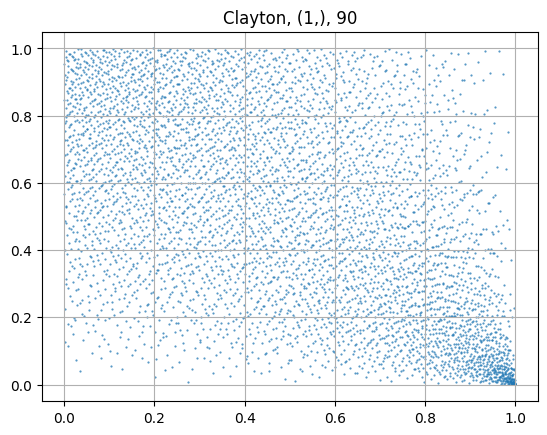

In [2]:
# simulate from a bcp with given family, parameter, rotation
fam, par, rot = "Clayton", (1,), 90
V_bcp = tvc.bicop.DataBiCop(fam=fam, par=par, rot=rot).sim(
    num_sim=5000, device=DEVICE, seed=0, is_sobol=True
)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
plt.title(f"{fam}, {par}, {rot}")
plt.grid()

## factory function


DataBiCop(fam='Clayton', negloglik=-963.221424341421, num_obs=5000, par=(1.00111255486831,), rot=90)

{'fam': 'Clayton',
 'rot': 90,
 'tau': -0.3336,
 'par': (1.0011,),
 'num_obs': 5_000,
 'negloglik': -963.2214,
 'aic': -1924.4428,
 'bic': -1917.9257}


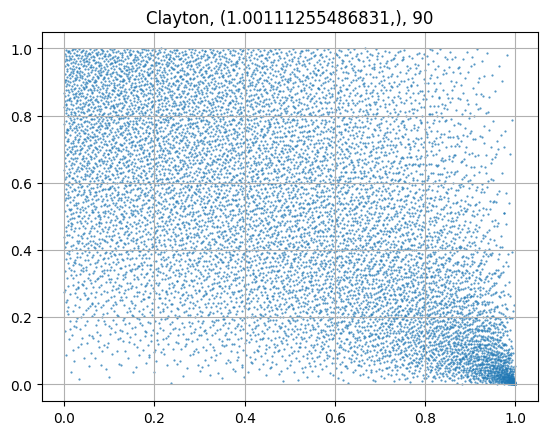

In [3]:
# make a DataBiCop object (from fitting the bicop obs);
mdl_bcp = tvc.bicop.bcp_from_obs(V_bcp)
display(mdl_bcp)
print(mdl_bcp)
# use the fitted model to simulation;
V_bcp = mdl_bcp.sim(num_sim=10000, device=DEVICE, seed=1, is_sobol=True)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
plt.title(f"{mdl_bcp.fam}, {mdl_bcp.par}, {mdl_bcp.rot}")
plt.grid()

## dataclass methods

In [4]:
lst_mtd = [_ for _ in dir(mdl_bcp) if not _.startswith("_")]
print(lst_mtd)
for _ in ("cdf", "hfunc1", "hfunc2", "hinv1", "hinv2", "l_pdf"):
    print(f"{_}\t{mdl_bcp.__getattribute__(_)(V_bcp)}")

['aic', 'bic', 'cdf', 'fam', 'hfunc1', 'hfunc2', 'hinv1', 'hinv2', 'l_pdf', 'negloglik', 'num_obs', 'num_par', 'par', 'rot', 'sim', 'tau']
cdf	tensor([[0.0845],
        [0.8184],
        [0.0378],
        ...,
        [0.4383],
        [0.0189],
        [0.2098]], device='cuda:0', dtype=torch.float64)
hfunc1	tensor([[0.3618],
        [0.9918],
        [0.1275],
        ...,
        [0.7890],
        [0.0810],
        [0.7100]], device='cuda:0', dtype=torch.float64)
hfunc2	tensor([[0.2962],
        [0.9744],
        [0.4101],
        ...,
        [0.8585],
        [0.3852],
        [0.4630]], device='cuda:0', dtype=torch.float64)
hinv1	tensor([[0.6584],
        [0.9227],
        [0.1915],
        ...,
        [0.6070],
        [0.0920],
        [0.8417]], device='cuda:0', dtype=torch.float64)
hinv2	tensor([[0.2431],
        [0.6103],
        [0.8092],
        ...,
        [0.5420],
        [0.9221],
        [0.2110]], device='cuda:0', dtype=torch.float64)
l_pdf	tensor([[ 0.1454],
      